In [35]:
%matplotlib inline
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import glob
from skimage.io import imread
from skimage.transform import resize
from tensorflow.python.framework.ops import reset_default_graph

def onehot(t, num_classes):
    out = np.zeros((t.shape[0], num_classes))
    for row, col in enumerate(t):
        out[row, col] = 1
    return out

# Kaggle challenge

In this lab we will work on a data science challenge from `kaggle.com`.
Kaggle is a website to participate in real life challenges.
Most competitions on kaggle have a dataset, an accuracy metric and a leaderboard to compare submissions.
You can read more about kaggle [here](https://www.kaggle.com/about).

OBS: You will need a kaggle account for this exercise!

The challenge we will pursue is the [_Leaf Classification_](https://www.kaggle.com/c/leaf-classification) challenge.
The dataset consists approximately 1,584 images of leaf specimens (16 samples each of 99 species) which have been converted to binary black leaves against white backgrounds. Three sets of features are also provided per image: a shape contiguous descriptor, an interior texture histogram, and a ﬁne-scale margin histogram. For each feature, a 64-attribute vector is given per leaf sample.

The first task in a kaggle competition is to download, understand and preprocess the data. This we will do in the first section.

Afterwards, we will look into the type of neural network best suited for handling this type of data. For images, usually the convolutional neural network does a pretty good job, for timeseries (like the shape) usually the RNN is the network of choice.

Lastly, we will train the model and put the outputs in a submission file that we can submit to kaggle.

## Download data

Go to the [data section](https://www.kaggle.com/c/leaf-classification/data) of the Leaf Classification competition on kaggle.

Next, download all of the available data (`sample_submission.csv`, `train.csv`, `test.csv`, `images`), accept the disclaimer if asked and unzip all folders into the `lab6` folder.
Such that

```
>ls $PATH\_TO\_FOLDER/tensorflow_tutorial/lab6
images  lab6_Kaggle.ipynb  README.md  sample_submission.csv  test.csv  train.csv
```

Below we will try to load the data into memory and print it.

In [36]:
image_paths = glob.glob("images/*")
print("Amount of images =", len(image_paths))

Amount of images = 1584


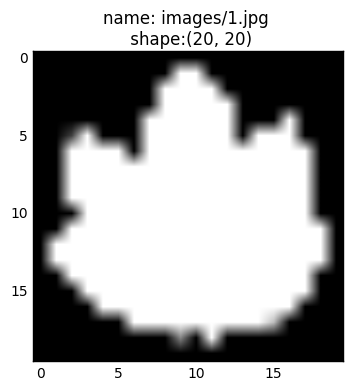

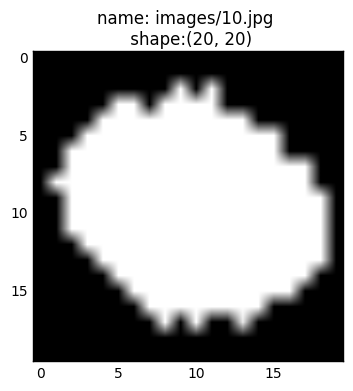

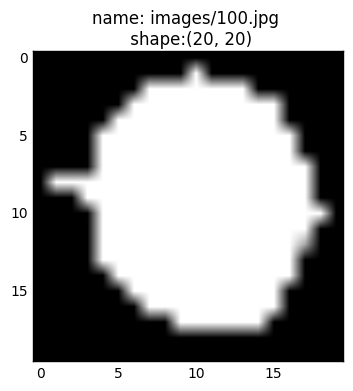

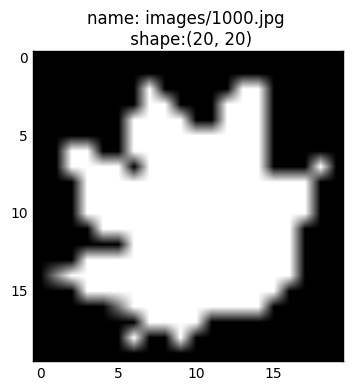

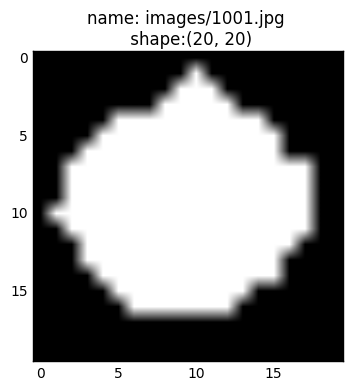

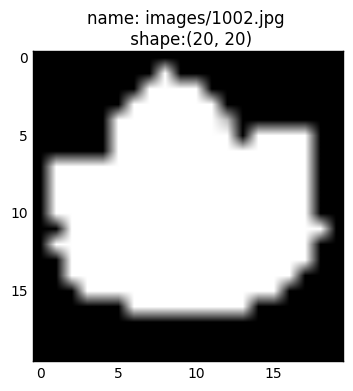

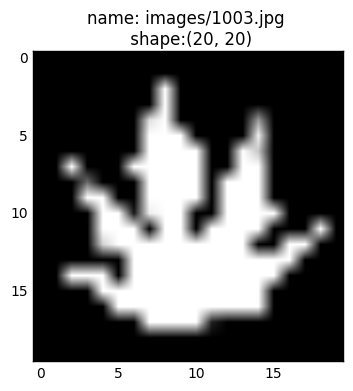

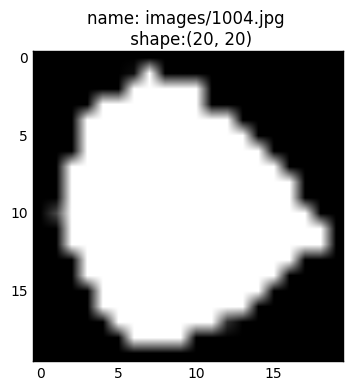

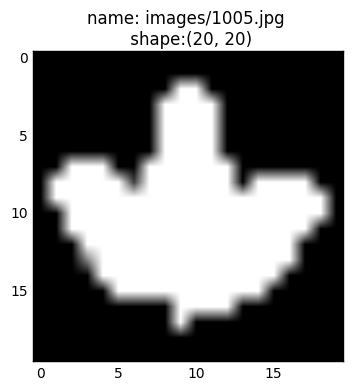

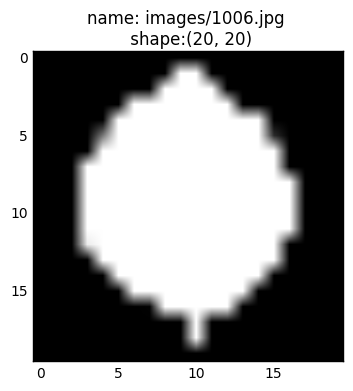

In [37]:
# now plot 10 images
# as we need all images to have the same dimensionality, we will resize and plot
# make the images as small as possible, until the difference between starts to get blurry
for i in range(10):
    image = imread(image_paths[i], as_grey=True)
    image = resize(image, output_shape=(20, 20))
    plt.imshow(image, cmap='gray')
    plt.title("name: %s \n shape:%s" % (image_paths[i], image.shape))
    plt.show()

In [38]:
# now loading the train.csv to find features for each training point
train = pd.read_csv('train.csv')
# notice how we "only" have 990 (989+0 elem) images for training, the rest is for testing
train.tail()

,id,species,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
985,1575,Magnolia_Salicifolia,0.060547,0.119140,0.007812,0.003906,0.000000,0.148440,0.017578,0.0,...,0.242190,0.000000,0.034180,0.000000,0.010742,0.000000,0.000000,0.000000,0.000000,0.018555
986,1578,Acer_Pictum,0.001953,0.003906,0.021484,0.107420,0.001953,0.000000,0.000000,0.0,...,0.170900,0.000000,0.018555,0.000000,0.011719,0.000000,0.000000,0.000977,0.000000,0.021484
987,1581,Alnus_Maximowiczii,0.001953,0.003906,0.000000,0.021484,0.078125,0.003906,0.007812,0.0,...,0.004883,0.000977,0.004883,0.027344,0.016602,0.007812,0.000000,0.027344,0.000000,0.001953
988,1582,Quercus_Rubra,0.000000,0.000000,0.046875,0.056641,0.009766,0.000000,0.000000,0.0,...,0.083008,0.030273,0.000977,0.002930,0.014648,0.000000,0.041992,0.000000,0.001953,0.002930
989,1584,Quercus_Afares,0.023438,0.019531,0.031250,0.015625,0.005859,0.019531,0.035156,0.0,...,0.000000,0.000000,0.002930,0.000000,0.012695,0.000000,0.000000,0.023438,0.025391,0.022461


In [39]:
# now do similar as in train example above for test.csv
test = pd.read_csv('test.csv')
# notice that we do not have species here, we need to predict that ..!
test.tail()

,id,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,margin9,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
589,1576,0.000000,0.000000,0.003906,0.015625,0.041016,0.000000,0.017578,0.000000,0.005859,...,0.098633,0.000000,0.004883,0.000000,0.003906,0.0,0.0,0.018555,0.000000,0.000977
590,1577,0.000000,0.003906,0.003906,0.005859,0.017578,0.000000,0.017578,0.005859,0.000000,...,0.012695,0.004883,0.004883,0.002930,0.009766,0.0,0.0,0.090820,0.000000,0.016602
591,1579,0.017578,0.029297,0.015625,0.013672,0.003906,0.015625,0.025391,0.000000,0.000000,...,0.073242,0.000000,0.028320,0.000000,0.001953,0.0,0.0,0.000000,0.042969,0.006836
592,1580,0.013672,0.009766,0.060547,0.025391,0.035156,0.025391,0.039062,0.000000,0.003906,...,0.003906,0.000000,0.000977,0.000000,0.011719,0.0,0.0,0.000000,0.011719,0.018555
593,1583,0.000000,0.117190,0.000000,0.019531,0.000000,0.136720,0.001953,0.005859,0.000000,...,0.107420,0.012695,0.016602,0.000977,0.004883,0.0,0.0,0.015625,0.000000,0.017578


In [40]:
# and now do similar as in train example above for test.csv
sample_submission = pd.read_csv('sample_submission.csv')
# accordingly to these IDs we need to provide the probability of a given plant being present
sample_submission.tail()

,id,Acer_Capillipes,Acer_Circinatum,Acer_Mono,Acer_Opalus,Acer_Palmatum,Acer_Pictum,Acer_Platanoids,Acer_Rubrum,Acer_Rufinerve,...,Salix_Fragilis,Salix_Intergra,Sorbus_Aria,Tilia_Oliveri,Tilia_Platyphyllos,Tilia_Tomentosa,Ulmus_Bergmanniana,Viburnum_Tinus,Viburnum_x_Rhytidophylloides,Zelkova_Serrata
589,1576,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,...,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101
590,1577,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,...,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101
591,1579,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,...,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101
592,1580,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,...,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101
593,1583,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,...,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101


In [41]:
# name all columns in train, should be 3 different columns with 64 values each
print(train.columns[2::64])

Index(['margin1', 'shape1', 'texture1'], dtype='object')


X.shape, (990, 192)
margin.shape, (990, 64)
shape.shape, (990, 64)
texture.shape, (990, 64)


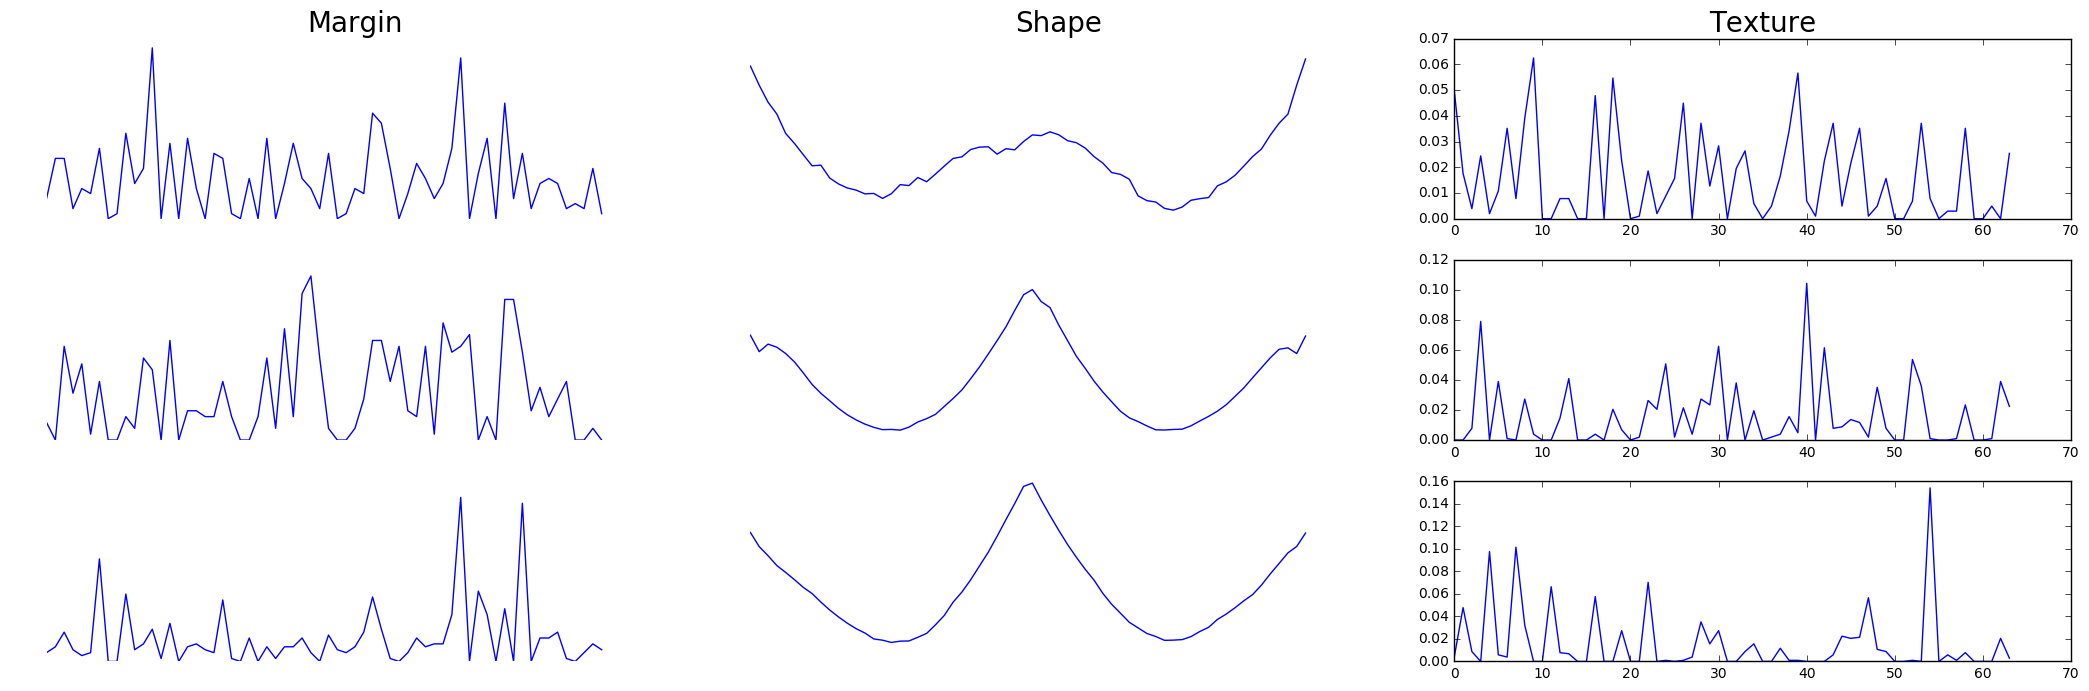

In [42]:
# try and extract and plot columns
X = train.as_matrix(columns=train.columns[2:])
print("X.shape,", X.shape)
margin = X[:, :64]
shape = X[:, 64:128]
texture = X[:, 128:]
print("margin.shape,", margin.shape)
print("shape.shape,", shape.shape)
print("texture.shape,", texture.shape)
# let us plot some of the features
plt.figure(figsize=(21,7))
for i in range(3):
    plt.subplot(3,3,1+i*3)
    plt.plot(margin[i])
    if i == 0:
        plt.title('Margin', fontsize=20)
    plt.axis('off')
    plt.subplot(3,3,2+i*3)
    plt.plot(shape[i])
    if i == 0:
        plt.title('Shape', fontsize=20)
    plt.axis('off')
    plt.subplot(3,3,3+i*3)
    plt.plot(texture[i])
    if i == 0:
        plt.title('Texture', fontsize=20)

plt.tight_layout()
plt.show()

# Exercise

1. Test various resizings of the image until you have found the smallest resizing of the image where you can still see differentiate between the images. Use IMAGE_SHAPE=(?, ?, 1) to reflect your choices.

So far we have learned about the feed forward neural network, the convolutional neural network and the recurrent neural network.
Given margin and texture are histograms, shape is a contigious value over a "time" dimension 

2. How would could Margin, Shape and Texture be represented for classification?

3. Describe what network you would build and how you would represent the data points (image, margin, shape and texture).

# Building data loader

In [52]:
%matplotlib inline
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import glob
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import StratifiedShuffleSplit   ## Ignore depreciation warning. Or refactor below
from skimage.io import imread
from skimage.transform import resize
from tensorflow.python.framework.ops import reset_default_graph
import os
import subprocess
import itertools
from datetime import datetime

def onehot(t, num_classes):
    out = np.zeros((t.shape[0], num_classes))
    for row, col in enumerate(t):
        out[row, col] = 1
    return out

In [53]:
class load_data():
    # data_train, data_test and le are public
    def __init__(self, train_path, test_path, image_paths, image_shape=(128, 128)):
        train_df = pd.read_csv(train_path)
        test_df = pd.read_csv(test_path)
        image_paths = image_paths
        image_shape = image_shape
        self._load(train_df, test_df, image_paths, image_shape)
        
    def _load(self, train_df, test_df, image_paths, image_shape):
        print("loading data ...")
        # load train.csv
        path_dict = self._path_to_dict(image_paths) # numerate image paths and make it a dict
        # merge image paths with data frame
        train_image_df = self._merge_image_df(train_df, path_dict)
        test_image_df = self._merge_image_df(test_df, path_dict)
        # label encoder-decoder (self. because we need it later)
        self.le = LabelEncoder().fit(train_image_df['species'])
        # labels for train
        t_train = self.le.transform(train_image_df['species'])
        # getting data
        train_data = self._make_dataset(train_image_df, image_shape, t_train)
        test_data = self._make_dataset(test_image_df, image_shape)     
        self.tt = train_data.copy()
        # need to reformat the train for validation split reasons in the batch_generator
        self.train = self._format_dataset(train_data, for_train=True)
        self.test = self._format_dataset(test_data, for_train=False)
        print("data loaded")
        

    def _path_to_dict(self, image_paths):
        path_dict = dict()
        for image_path in image_paths:
            num_path = int(os.path.basename(image_path[:-4]))
            path_dict[num_path] = image_path
        return path_dict

    def _merge_image_df(self, df, path_dict):
        split_path_dict = dict()
        for index, row in df.iterrows():
            split_path_dict[row['id']] = path_dict[row['id']]
        image_frame = pd.DataFrame(list(split_path_dict.values()), columns=['image'])
        df_image =  pd.concat([image_frame, df], axis=1)
        return df_image
    

    def _make_dataset(self, df, image_shape, t_train=None):
        if t_train is not None:
            print("loading train ...")
        else:
            print("loading test ...")
        # make dataset
        data = dict()
        # merge image with 3x64 features
        for i, dat in enumerate(df.iterrows()):
            index, row = dat
            sample = dict()
            if t_train is not None:
                features = row.drop(['id', 'species', 'image'], axis=0).values
            else:
                features = row.drop(['id', 'image'], axis=0).values
            sample['margin'] = features[:64]
            sample['shape'] = features[64:128]
            sample['texture'] = features[128:]
            if t_train is not None:
                sample['t'] = np.asarray(t_train[i], dtype='int32')
            image = imread(row['image'], as_grey=True)
            image = resize(image, output_shape=image_shape)
            image = np.expand_dims(image, axis=2)
            sample['image'] = image   
            data[row['id']] = sample
            if i % 100 == 0:
                print("\t%d of %d" % (i, len(df)))
        return data

    def _format_dataset(self, data_dict, for_train):
        # making arrays with all data in, is nessesary when doing validation split
        data = dict()
        value = list(data_dict.values())[0]
        img_tot_shp = tuple([len(data_dict)] + list(value['image'].shape))
        data['images'] = np.zeros(img_tot_shp, dtype='float32')
        feature_tot_shp = (len(data_dict), 64)
        data['margins'] = np.zeros(feature_tot_shp, dtype='float32')
        data['shapes'] = np.zeros(feature_tot_shp, dtype='float32')
        data['textures'] = np.zeros(feature_tot_shp, dtype='float32')
        if for_train:
            data['ts'] = np.zeros((len(data_dict),), dtype='int32')
        else:
            data['ids'] = np.zeros((len(data_dict),), dtype='int32')
        for i, pair in enumerate(data_dict.items()):
            key, value = pair
            data['images'][i] = value['image']
            data['margins'][i] = value['margin']
            data['shapes'][i] = value['shape']
            data['textures'][i] = value['texture']
            if for_train:
                data['ts'][i] = value['t']
            else:
                data['ids'][i] = key
        return data

In [66]:
# loading data and setting up constants
TRAIN_PATH = "train.csv"
TEST_PATH = "test.csv"
IMAGE_PATHS = glob.glob("images/*.jpg")
NUM_CLASSES = 99 # len(train.species.unique())
IMAGE_SHAPE = (64, 64, 1)
NUM_FEATURES = 64 # for all three features, margin, shape and texture
# train holds both X (input) and t (target/truth)
data = load_data(train_path=TRAIN_PATH, test_path=TEST_PATH,
                 image_paths=IMAGE_PATHS, image_shape=IMAGE_SHAPE[:2])
# to visualize the size of the dimensions of the data
print()
print("@@@Shape checking of data sets@@@")
print()
print("TRAIN")
print("\timages\t%s%f" % (data.train['images'].shape, data.train['images'].mean()))
print("\tmargins\t%s\t%f" % (data.train['margins'].shape, data.train['margins'].mean()))
print("\tshapes\t%s\t%f" % (data.train['shapes'].shape, data.train['shapes'].mean()))
print("\ttextures%s\t%f" % (data.train['textures'].shape, data.train['textures'].mean()))
print("\tts\t %s" % (data.train['ts'].shape))
print("\twhile training, batch_generator will onehot encode ts to (batch_size, num_classes)")
print()
print("TEST")
print("\timages\t%s\t%f" % (data.test['images'].shape, data.test['images'].mean()) )
print("\tmargins\t%s\t%f" % (data.test['margins'].shape, data.test['margins'].mean()))
print("\tshapes\t%s\t%f" % (data.test['shapes'].shape, data.test['shapes'].mean()))
print("\ttextures%s\t%f" % (data.test['textures'].shape, data.test['textures'].mean()))
print("\tids\t%s" % (data.test['ids'].shape))

loading data ...
loading train ...
	0 of 990
	100 of 990
	200 of 990
	300 of 990
	400 of 990
	500 of 990
	600 of 990
	700 of 990
	800 of 990
	900 of 990
loading test ...
	0 of 594
	100 of 594
	200 of 594
	300 of 594
	400 of 594
	500 of 594
data loaded

@@@Shape checking of data sets@@@

TRAIN
	images	(990, 64, 64, 1)0.462128
	margins	(990, 64)	0.015625
	shapes	(990, 64)	0.000607
	textures(990, 64)	0.015625
	ts	 990
	while training, batch_generator will onehot encode ts to (batch_size, num_classes)

TEST
	images	(594, 64, 64, 1)	0.463122
	margins	(594, 64)	0.015625
	shapes	(594, 64)	0.000604
	textures(594, 64)	0.015625
	ids	594


# batch generator

While training, we will not directly access the entire dataset, instead we have a `batch_generator` function to give us inputs aligned with their targets/ids in a size that our model can handle in memory (batch\_size).

Furthermore, the `batch_generator` also handles validation splitting.

In [67]:
class batch_generator():
    def __init__(self, data, batch_size=64, num_classes=99,
                 num_iterations=5e3, num_features=64, seed=42, val_size=0.1):
        print("initiating batch generator")
        self._train = data.train
        self._test = data.test
        # get image size
        value = self._train['images'][0]
        self._image_shape = list(value.shape)
        self._batch_size = batch_size
        self._num_classes = num_classes
        self._num_iterations = num_iterations
        self._num_features = num_features
        self._seed = seed
        self._val_size = 0.1
        self._valid_split()
        print("batch generator initiated ...")

    def _valid_split(self):
        self._idcs_train, self._idcs_valid = iter(
            StratifiedShuffleSplit(self._train['ts'],
                                   n_iter=1,
                                   test_size=self._val_size,
                                   random_state=self._seed)).__next__()
    def _shuffle_train(self):
        np.random.shuffle(self._idcs_train)

    def _batch_init(self, purpose):
        assert purpose in ['train', 'valid', 'test']
        batch_holder = dict()
        batch_holder['margins'] = np.zeros((self._batch_size, self._num_features), dtype='float32')
        batch_holder['shapes'] = np.zeros((self._batch_size, self._num_features), dtype='float32')
        batch_holder['textures'] = np.zeros((self._batch_size, self._num_features), dtype='float32')
        batch_holder['images'] = np.zeros(tuple([self._batch_size] + self._image_shape), dtype='float32')
        if (purpose == "train") or (purpose == "valid"):
            batch_holder['ts'] = np.zeros((self._batch_size, self._num_classes), dtype='float32')          
        else:
            batch_holder['ids'] = []
        return batch_holder

    def gen_valid(self):
        batch = self._batch_init(purpose='train')
        i = 0
        for idx in self._idcs_valid:
            batch['margins'][i] = self._train['margins'][idx]
            batch['shapes'][i] = self._train['shapes'][idx]
            batch['textures'][i] = self._train['textures'][idx]
            batch['images'][i] = self._train['images'][idx]
            batch['ts'][i] = onehot(np.asarray([self._train['ts'][idx]], dtype='float32'), self._num_classes)
            i += 1
            if i >= self._batch_size:
                yield batch, i
                batch = self._batch_init(purpose='valid')
                i = 0
        if i != 0:
            yield batch, i

    def gen_test(self):
        batch = self._batch_init(purpose='test')
        i = 0
        for idx in range(len(self._test['ids'])):
            batch['margins'][i] = self._test['margins'][idx]
            batch['shapes'][i] = self._test['shapes'][idx]
            batch['textures'][i] = self._test['textures'][idx]
            batch['images'][i] = self._test['images'][idx]
            batch['ids'].append(self._test['ids'][idx])
            i += 1
            if i >= self._batch_size:
                yield batch, i
                batch = self._batch_init(purpose='test')
                i = 0
        if i != 0:
            yield batch, i
            

    def gen_train(self):
        batch = self._batch_init(purpose='train')
        iteration = 0
        i = 0
        while True:
            # shuffling all batches
            self._shuffle_train()
            for idx in self._idcs_train:
                # extract data from dict
                batch['margins'][i] = self._train['margins'][idx]
                batch['shapes'][i] = self._train['shapes'][idx]
                batch['textures'][i] = self._train['textures'][idx]
                batch['images'][i] = self._train['images'][idx]
                batch['ts'][i] = onehot(np.asarray([self._train['ts'][idx]], dtype='float32'), self._num_classes)
                i += 1
                if i >= self._batch_size:
                    yield batch
                    batch = self._batch_init(purpose='train')
                    i = 0
                    iteration += 1
                    if iteration >= self._num_iterations:
                        break

In [68]:
dummy_batch_gen = batch_generator(data, batch_size=64, num_classes=99, num_iterations=5e3, seed=42)
train_batch = dummy_batch_gen.gen_train().__next__()
valid_batch, i = dummy_batch_gen.gen_valid().__next__()
test_batch, i = dummy_batch_gen.gen_test().__next__()

print()
print("@@@Shape/mean checking of batches@@@")
print()
print("TRAIN")
print("\timages,", train_batch['images'].shape)
print("\tmargins,", train_batch['margins'].shape)
print("\tshapes,", train_batch['shapes'].shape)
print("\ttextures,", train_batch['textures'].shape)
print("\tts,", train_batch['ts'].shape)
print()
print("VALID")
print("\timages,", valid_batch['images'].shape)
print("\tmargins,", valid_batch['margins'].shape)
print("\tshapes,", valid_batch['shapes'].shape)
print("\ttextures,", valid_batch['textures'].shape)
print("\tts,", valid_batch['ts'].shape)
print()
print("TEST")
print("\timages,", test_batch['images'].shape)
print("\tmargins,", test_batch['margins'].shape)
print("\tshapes,", test_batch['shapes'].shape)
print("\ttextures,", test_batch['textures'].shape)
print("\tids,", len(test_batch['ids']))
# notice that mean is very different, which is why we use batch_norm in all input data in model

initiating batch generator
batch generator initiated ...

@@@Shape/mean checking of batches@@@

TRAIN
	images, (64, 64, 64, 1)
	margins, (64, 64)
	shapes, (64, 64)
	textures, (64, 64)
	ts, (64, 99)

VALID
	images, (64, 64, 64, 1)
	margins, (64, 64)
	shapes, (64, 64)
	textures, (64, 64)
	ts, (64, 99)

TEST
	images, (64, 64, 64, 1)
	margins, (64, 64)
	shapes, (64, 64)
	textures, (64, 64)
	ids, 64


//anaconda/envs/smartypy/lib/python3.5/site-packages/ipykernel/__main__.py:21: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


# Build the model

### Documentation on contrib layers
Check out the [github page](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/layers/python/layers/layers.py) for information on contrib layers (not well documented in their api).

In [69]:
# contrib layers similar to wrappings used in Lasagne (for theano) or Keras
from tensorflow.contrib.layers import fully_connected, convolution2d, flatten, batch_norm, max_pool2d, dropout
from tensorflow.python.ops.nn import relu, elu, relu6, sigmoid, tanh, softmax
from tensorflow.python.ops.nn import dynamic_rnn

In [70]:
# wrapping conv with batch_norm
def conv(l_in, num_outputs, kernel_size, scope, stride=1):
    return convolution2d(l_in, num_outputs=num_outputs, kernel_size=kernel_size,
                         stride=stride, normalizer_fn=batch_norm, scope=scope)

# pre-activation: http://arxiv.org/abs/1603.05027
# wrapping convolutions and batch_norm
def conv_pre(l_in, num_outputs, kernel_size, scope, stride=1):
    l_norm = batch_norm(l_in)
    l_relu = relu(l_norm)
    return convolution2d(l_relu, num_outputs=num_outputs, kernel_size=kernel_size,
                         stride=stride, activation_fn=None, scope=scope)
# easy to use pool function
def pool(l_in, scope, kernel_size=(3, 3)):
    return max_pool2d(l_in, kernel_size=kernel_size, scope=scope) # (3, 3) has shown to work better than (2, 2)

In [89]:
# hyperameters of the model
height, width, channels = IMAGE_SHAPE
# resetting the graph ...
reset_default_graph()

# Setting up placeholder, this is where your data enters the graph!
x_image_pl = tf.placeholder(tf.float32, [None, height, width, channels], name="x_image_pl")
x_margin_pl = tf.placeholder(tf.float32, [None, NUM_FEATURES], name="x_margin_pl")
x_shape_pl = tf.placeholder(tf.float32, [None, NUM_FEATURES], name="x_shape_pl")
x_texture_pl = tf.placeholder(tf.float32, [None, NUM_FEATURES], name="x_texture_pl")
is_training_pl = tf.placeholder(tf.bool, name="is_training_pl")

# Building the layers of the neural network
# we define the variable scope, so we more easily can recognise our variables later

## IMAGE
l_conv1_a = conv(x_image_pl, 16, (5, 5), scope="l_conv1_a")
l_pool1 = pool(l_conv1_a, scope="l_pool1")
l_conv2_a = conv(l_pool1, 16, (5, 5), scope="l_conv2_a")
l_pool2 = pool(l_conv2_a, scope="l_pool2")
l_conv3_a = conv(l_pool2, 16, (5, 5), scope="l_conv3_a")
l_pool3 = pool(l_conv3_a, scope="l_pool3")
l_conv4_a = conv(l_pool3, 16, (5, 5), scope="l_conv4_a")
l_pool4 = pool(l_conv4_a, scope="l_pool4")
l_flatten = flatten(l_pool4, scope="flatten")

## RNN
# define the cell of your RNN
shape_cell = tf.nn.rnn_cell.GRUCell(100)
# run the RNN as outputs, state = tf.nn.dynamic_rnn(cell, ...)
# given we run many-to-one we only care about the last state, so only
# shape_state is defined
_, shape_state = tf.nn.dynamic_rnn(cell=shape_cell,
inputs = tf.expand_dims(batch_norm(x_shape_pl), 2), dtype=tf.float32, scope="shape_rnn")

## COMBINE
# All??
features = tf.concat(concat_dim=1, values=[x_margin_pl, shape_state, x_texture_pl, l_flatten], name="all_features")
# use margin, shape and texture only
# features = tf.concat(concat_dim=1, values=[x_margin_pl, x_shape_pl, x_texture_pl], name="features")
# uncomment to use image only
#features = l_flatten
# uncomment to use margin, rnn_state on shape and texture only
#features = tf.concat(concat_dim=1, values=[x_margin_pl, shape_state, x_texture_pl], name="features")
features = batch_norm(features, scope='features_bn')
l2 = fully_connected(features, num_outputs=256, activation_fn=relu, normalizer_fn=batch_norm, scope="l2")
l2 = dropout(l2, is_training=is_training_pl, scope="l2_dropout")
y = fully_connected(features, NUM_CLASSES, activation_fn=softmax, scope="y")

# add TensorBoard summaries for all variables
tf.contrib.layers.summarize_variables()

[<tf.Tensor 'l_conv1_a/weights_summary:0' shape=() dtype=string>,
 <tf.Tensor 'l_conv1_a/BatchNorm/beta_summary:0' shape=() dtype=string>,
 <tf.Tensor 'l_conv1_a/BatchNorm/moving_mean_summary:0' shape=() dtype=string>,
 <tf.Tensor 'l_conv1_a/BatchNorm/moving_variance_summary:0' shape=() dtype=string>,
 <tf.Tensor 'l_conv2_a/weights_summary:0' shape=() dtype=string>,
 <tf.Tensor 'l_conv2_a/BatchNorm/beta_summary:0' shape=() dtype=string>,
 <tf.Tensor 'l_conv2_a/BatchNorm/moving_mean_summary:0' shape=() dtype=string>,
 <tf.Tensor 'l_conv2_a/BatchNorm/moving_variance_summary:0' shape=() dtype=string>,
 <tf.Tensor 'l_conv3_a/weights_summary:0' shape=() dtype=string>,
 <tf.Tensor 'l_conv3_a/BatchNorm/beta_summary:0' shape=() dtype=string>,
 <tf.Tensor 'l_conv3_a/BatchNorm/moving_mean_summary:0' shape=() dtype=string>,
 <tf.Tensor 'l_conv3_a/BatchNorm/moving_variance_summary:0' shape=() dtype=string>,
 <tf.Tensor 'l_conv4_a/weights_summary:0' shape=() dtype=string>,
 <tf.Tensor 'l_conv4_a/Ba

In [90]:
# PRINT NETWORK (good practice to also include outcommented code when using it)

print("x_image_pl,", x_image_pl.get_shape())
print("x_margin_pl,", x_margin_pl.get_shape())
print("x_shape_pl,", x_shape_pl.get_shape())
print("x_texture_pl,", x_texture_pl.get_shape())
print("features,", features.get_shape())
print("y,", y.get_shape())

# # for the MLP
# print("l2,", l2.get_shape())
# # for the RNN
# print("shape_state,", shape_state.get_shape())
# # for the CNN
# print("l_conv1_a,", l_conv1_a.get_shape())
# # ...
# print("l_pool4,", l_pool4.get_shape())
# print("l_flatten,", l_flatten.get_shape())

x_image_pl, (?, 64, 64, 1)
x_margin_pl, (?, 64)
x_shape_pl, (?, 64)
x_texture_pl, (?, 64)
features, (?, 372)
y, (?, 99)


# Build the cost function

In [91]:
clip_norm = 1
# ts_pl is a placeholder variable taking on the value of the target batch.
ts_pl = tf.placeholder(tf.float32, [None, NUM_CLASSES], name="targets_pl")
lr_pl = tf.placeholder(tf.float32, [], name="learning_rate_pl")

def loss_and_acc(preds):
    # computing cross entropy per sample
    cross_entropy = -tf.reduce_sum(ts_pl * tf.log(preds+1e-10), reduction_indices=[1])
    # averaging over samples
    loss = tf.reduce_mean(cross_entropy)
    # if you want regularization
    reg_scale = 0.0001
    regularize = tf.contrib.layers.l2_regularizer(reg_scale)
    params = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
    reg_term = sum([regularize(param) for param in params])
    loss += reg_term
    # calculate accuracy
    argmax_y = tf.to_int32(tf.argmax(preds, dimension=1))
    argmax_t = tf.to_int32(tf.argmax(ts_pl, dimension=1))
    correct = tf.to_float(tf.equal(argmax_y, argmax_t))
    accuracy = tf.reduce_mean(correct)
    return loss, accuracy, argmax_y

# loss, accuracy and prediction
loss, accuracy, prediction = loss_and_acc(y)

loss_valid = loss
accuracy_valid = accuracy
loss_valid, accuracy_valid, _ = loss_and_acc(y)

# defining our optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)

# applying the gradients
grads_and_vars = optimizer.compute_gradients(loss)
gradients, variables = zip(*grads_and_vars)  # unzip list of tuples
clipped_gradients, global_norm = (
    tf.clip_by_global_norm(gradients, clip_norm) )
clipped_grads_and_vars = zip(clipped_gradients, variables)

# make training op for applying the gradients
train_op = optimizer.apply_gradients(clipped_grads_and_vars)

# make tensorboard summeries
tf.scalar_summary('train/global gradient norm', global_norm)
tf.scalar_summary('train/loss', loss)
tf.scalar_summary('train/accuracy', accuracy)
tf.scalar_summary('validation/loss', loss_valid)
tf.scalar_summary('validation/accuracy', accuracy_valid)

<tf.Tensor 'ScalarSummary_4:0' shape=() dtype=string>

In [92]:
#Test the forward pass
_img_shape = tuple([45]+list(IMAGE_SHAPE))
_feature_shape = (45, NUM_FEATURES)
_x_image = np.random.normal(0, 1, _img_shape).astype('float32') #dummy data
_x_margin = np.random.normal(0, 1, _feature_shape).astype('float32')
_x_shape = np.random.normal(0, 1, _feature_shape).astype('float32')
_x_texture = np.random.normal(0, 1, _feature_shape).astype('float32')

# restricting memory usage, TensorFlow is greedy and will use all memory otherwise
gpu_opts = tf.GPUOptions(per_process_gpu_memory_fraction=0.8)
# initialize the Session
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts))
# test the forward pass
sess.run(tf.initialize_all_variables())
feed_dict = {x_image_pl: _x_image,
             x_margin_pl: _x_margin,
             x_shape_pl: _x_shape,
             x_texture_pl: _x_texture,
             is_training_pl: False}
res_forward_pass = sess.run(fetches=[y], feed_dict=feed_dict)
print("y", res_forward_pass[0].shape)

y (45, 99)


In [ ]:
#Training Loop
BATCH_SIZE = 64
ITERATIONS = 1e4
LOG_FREQ = 10
VALIDATION_SIZE = 0.1 # 0.1 is ~ 100 samples for valition
SEED = 42
DROPOUT = False
LEARNING_RATE = 0.00025
VALID_EVERY = 100

batch_gen = batch_generator(data, batch_size=BATCH_SIZE, num_classes=NUM_CLASSES,
                            num_iterations=ITERATIONS, seed=SEED, val_size=VALIDATION_SIZE)

# setup and write summaries
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
summaries_path = "tensorboard/%s/logs" % (timestamp)
summaries = tf.merge_all_summaries()
summarywriter = tf.train.SummaryWriter(summaries_path, sess.graph)

train_loss = []
train_acc = []
print("\ttrain_loss \ttrain_acc \tvalid_loss \tvalid_acc")
for i, batch_train in enumerate(batch_gen.gen_train()):
    if i>=ITERATIONS:
        break
    fetches_train = [train_op, loss, accuracy, summaries]
    feed_dict_train = {
        x_image_pl: batch_train['images'],
        x_margin_pl: batch_train['margins'],
        x_shape_pl: batch_train['shapes'],
        x_texture_pl: batch_train['textures'],
        ts_pl: batch_train['ts'],
        is_training_pl: DROPOUT,
        lr_pl: LEARNING_RATE,
        
    }
    res_train = sess.run(fetches=fetches_train, feed_dict=feed_dict_train)
    if i % LOG_FREQ == 0:
        summarywriter.add_summary(res_train[3], i)
    train_loss.append(res_train[1])
    train_acc.append(res_train[2])
    
    # validate
    if i % VALID_EVERY == 0:
        cur_acc = 0
        cur_loss = 0
        tot_num = 0
        # batch validation
        for batch_valid, num in batch_gen.gen_valid():
            # fetches and feed_dict for validation
            fetches_valid = [loss_valid, accuracy_valid, summaries]
            feed_dict_valid = {
                x_image_pl: batch_valid['images'],
                x_margin_pl: batch_valid['margins'],
                x_shape_pl: batch_valid['shapes'],
                x_texture_pl: batch_valid['textures'],
                ts_pl: batch_valid['ts'],
                is_training_pl: False,
            }
            # run validation
            res_valid = sess.run(fetches=fetches_valid, feed_dict=feed_dict_valid)
            # tensorboard and costs
            summarywriter.add_summary(res_valid[2], i)
            cur_loss += res_valid[0]*num
            cur_acc += res_valid[1]*num
            tot_num += num
        valid_loss = cur_loss / float(tot_num)
        valid_acc = (cur_acc / float(tot_num)) * 100
        train_loss = sum(train_loss) / float(len(train_loss))
        train_acc = sum(train_acc) / float(len(train_acc)) * 100
        print("%d:\t  %.2f\t\t  %.1f\t\t  %.2f\t\t  %.1f" % (i, train_loss, train_acc, valid_loss, valid_acc))
        train_loss = []
        train_acc = []

initiating batch generator
batch generator initiated ...
	train_loss 	train_acc 	valid_loss 	valid_acc


//anaconda/envs/smartypy/lib/python3.5/site-packages/ipykernel/__main__.py:21: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


0:	  5.00		  1.6		  4.13		  2.0
100:	  1.81		  71.0		  0.94		  71.7


# TensorBoard

The code above has TensorBoard tracking histograms of all layers, train gradient norm, accuracy, loss, validation accuracy and loss.

The TensorBoard summaries are written to the tensorboard folder. To enable TensorBoard start a new Docker instance (in similar fashion to the one you are running) forwarding port 6006, as below

```
> docker run -p 6006:6006 -v $PATH\_TO\_FOLDER/tensorflow_tutorial:/mnt/myproject -it alrojo/tf-sklearn-cpu
> cd mnt/myproject/lab6_Kaggle
> tensorboard --logdir=tensorboard
```
Now open a browser window and connect to `localhost:6006`, here you should find the TensorBoard of your current run.

NOTE: when using docker toolbox on windows the port will probably not bind to local host, instead you must find the port it binds to by typing the following in your docker prompt

>docker-machine ip

this should give you an ip that you can replace with localhost.

Note: CTRL+c when running TensorBoard might cause the program to halt. To terminate it just exit the terminal, open a new terminal, type

```
> docker ps
```

if your output looks something like this:
```
CONTAINER ID        IMAGE                   COMMAND             CREATED             STATUS              PORTS                              NAMES
e62ed10401cd        alrojo/tf-sklearn-cpu   "/bin/bash"         16 minutes ago      Up 16 minutes       0.0.0.0:6006->6006/tcp, 8888/tcp   gigantic_euler
7846236dbf57        alrojo/tf-sklearn-cpu   "/bin/bash"         About an hour ago   Up About an hour    6006/tcp, 0.0.0.0:8888->8888/tcp   high_gates

```

That means you still have the docker running and you need to shut it down if you want to run a new docker with the same port forwarding. To do, use either the `CONTAINER ID` or the `NAMES` and run:

```
> docker kill gigantic_euler
```
Note: In my case the `NAMES` was `gigantic_euler`, yours might be different.

# Submission to Kaggle

First we have to make testset predictions, then we have to place it in the submission file and the upload to kaggle for our score! You can upload at max 5 submissions a day.

In [21]:
# GET PREDICTIONS
# containers to collect ids and predictions
ids_test = []
preds_test = []
# run like with validation
for batch_test, num in batch_gen.gen_test():
    # fetching for test we only need y
    fetches_test = [y]
    # same as validation, but no batch['ts']
    feed_dict_test = {
        x_image_pl: batch_test['images'],
        x_margin_pl: batch_test['margins'],
        x_shape_pl: batch_test['shapes'],
        x_texture_pl: batch_test['textures'],
        is_training_pl: False
    }
    # get the result
    res_test = sess.run(fetches=fetches_test, feed_dict=feed_dict_test)
    y_out = res_test[0]
    ids_test.append(batch_test['ids'])
    if num!=len(y_out):
        # in case of the last batch, num will be less than batch_size
        y_out = y_out[:num]
    preds_test.append(y_out)
# concatenate it all, to form one list/array
ids_test = list(itertools.chain.from_iterable(ids_test))
preds_test = np.concatenate(preds_test, axis=0)
assert len(ids_test) == len(preds_test)

# Make submission file

In [22]:
preds_df = pd.DataFrame(preds_test, columns=data.le.classes_)
ids_test_df = pd.DataFrame(ids_test, columns=["id"])
submission = pd.concat([ids_test_df, preds_df], axis=1)
submission.to_csv('submission_mlp.csv', index=False)
# below prints the submission, can be removed and replaced with code block below
submission

,id,Acer_Capillipes,Acer_Circinatum,Acer_Mono,Acer_Opalus,Acer_Palmatum,Acer_Pictum,Acer_Platanoids,Acer_Rubrum,Acer_Rufinerve,...,Salix_Fragilis,Salix_Intergra,Sorbus_Aria,Tilia_Oliveri,Tilia_Platyphyllos,Tilia_Tomentosa,Ulmus_Bergmanniana,Viburnum_Tinus,Viburnum_x_Rhytidophylloides,Zelkova_Serrata
0,4,5.564099e-09,3.995893e-09,3.215826e-10,3.579184e-05,1.534015e-09,3.922370e-11,3.727405e-08,2.401681e-09,4.123072e-10,...,6.463605e-10,5.186318e-06,1.572735e-08,2.441709e-09,4.433265e-07,1.181075e-09,2.073514e-11,3.742596e-10,1.466789e-09,6.290616e-10
1,7,4.234810e-09,3.445131e-08,1.008688e-07,1.249469e-06,1.099376e-07,3.611913e-08,2.375303e-06,1.860793e-08,5.416962e-09,...,2.938037e-09,3.328846e-08,9.049756e-09,1.432459e-08,4.233897e-09,2.621590e-06,1.648111e-09,1.533108e-06,2.634925e-09,6.199036e-06
2,9,9.157161e-08,9.980009e-01,1.720776e-07,3.295709e-07,1.197206e-03,1.378777e-06,2.659681e-08,3.054111e-05,2.208277e-05,...,3.714409e-07,1.045037e-07,1.498809e-07,2.413588e-08,1.329892e-10,8.576847e-08,2.674542e-07,1.345941e-09,4.951499e-09,2.277303e-04
3,12,3.137234e-10,7.157261e-05,4.558301e-08,2.259347e-09,2.805615e-07,1.204050e-09,2.721501e-05,4.671056e-08,7.129248e-05,...,1.857425e-07,2.992218e-09,2.208566e-06,3.269031e-08,2.777161e-07,4.933698e-06,2.635645e-03,1.132239e-07,6.438043e-07,3.766651e-04
4,13,5.795870e-08,1.015203e-07,1.287603e-10,9.806435e-10,3.148348e-08,5.977766e-11,3.276833e-07,8.885695e-09,2.571370e-06,...,5.008176e-07,1.483564e-09,8.166779e-06,4.322440e-08,1.759922e-05,3.189810e-06,7.981434e-05,2.553334e-07,3.665428e-08,1.496972e-09
5,16,2.953344e-06,6.158201e-07,9.883947e-07,9.215780e-01,1.191772e-06,1.115861e-07,1.191132e-05,2.849477e-04,2.764408e-06,...,2.062067e-04,2.890773e-05,2.903316e-05,6.455876e-05,2.516816e-04,2.165608e-04,2.039107e-06,1.924955e-06,2.673305e-04,1.474009e-05
6,19,2.618619e-06,1.213384e-06,1.164345e-06,9.973845e-01,1.977085e-07,3.813481e-08,1.879613e-06,5.791098e-07,9.794209e-08,...,1.361041e-07,5.301088e-06,4.502169e-06,1.781421e-06,2.038559e-05,1.202596e-04,2.928770e-08,2.013095e-06,8.148651e-06,4.414580e-04
7,23,1.599135e-10,5.748869e-06,1.504531e-06,2.391018e-06,1.457821e-07,9.795280e-05,2.314170e-06,8.684391e-10,7.397863e-11,...,4.542820e-09,1.274733e-07,3.446437e-09,2.159990e-09,4.277613e-07,1.438084e-09,2.114243e-10,2.195948e-07,5.251225e-08,1.933370e-07
8,24,9.315323e-07,1.018916e-07,1.891389e-08,9.358384e-11,5.781123e-08,1.202895e-06,1.173221e-06,2.271810e-08,7.574131e-06,...,8.600087e-09,1.222477e-09,4.911558e-10,1.202762e-07,5.178366e-10,7.382057e-10,5.323598e-11,4.985075e-12,2.322560e-11,6.856449e-11
9,28,1.210373e-04,2.806766e-05,1.315054e-07,8.721123e-08,2.161358e-07,3.098198e-08,2.940067e-06,3.875687e-05,9.994276e-01,...,7.775509e-06,2.366486e-07,1.401758e-05,1.583462e-07,1.801642e-06,1.189907e-04,3.301221e-06,4.633716e-11,4.395520e-09,1.093372e-06


# Upload submission

1. Go to `https://www.kaggle.com/c/leaf-classification/`
2. Make a submission
3. Click or drop your submission here (writing a description is good practice)
4. Submit

Success! now you can view your score on the leaderboard, try and see if you can beat me! (Alexander Rosenberg Johansen: 0.06399)

# Exercises

When doing these exercises nothing is sacred, you can change learning rate, try testing various learning rates, batch sizes, validation sizes, etc. And most importantly, the validation set is very small (only 1 sample per class), so try different seeds if evaluating the same model twice.

Describe how each of below tasks effects training:

1. Include l2 (fully connected and dropout layer)
2. Set DROPOUT to TRUE
3. Include L2 regularization
4. Try with L1 regularization (look at [tensorflow API](https://www.tensorflow.org/versions/r0.10/api_docs/python/contrib.layers.html#regularizers) for instructions)
5. Use only the image for training (with CNN) - comment on the increased time between iterations.
6. Use dropout between the convolutional layers
7. Include the RNN part
8. (optional) Try the best performing model with more iterations and aneal the model
9. (optional) Run Tensorboard, what do you see iTry the best performing model with more iterations and aneal the model